## Import Library

In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import accuracy_score
from imblearn.metrics import sensitivity_specificity_support
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
import xgboost as xgb
pd.set_option('display.max_columns', None)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve

import shap

In [2]:
def performances_hard_decision(y_test, y_proba, threshold_of_interest=0.5, youden=False):
   
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
   
    print("AUROC: {:.3f}".format(roc_auc))
   
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print("AUPRC: {:.3f}".format(pr_auc))

    
    if(youden):
        threshold_of_interest = thresholds[np.argmax(tpr - fpr)]
    
    y_pred = y_proba >= threshold_of_interest
   
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    ppv = tp / (tp+fp)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    npv = tn / (tn+fn)
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    f1 = (2 * ppv * sensitivity) / (ppv + sensitivity)
   
    print("specificity: {:.3f}".format(specificity))
    print("sensitivity: {:.3f}".format(sensitivity))
    print("PPV: {:.3f}".format(ppv))
    print("NPV: {:.3f}".format(npv))
    print("f1: {:.3f}".format(f1))
    print("accuracy: {:.3f}".format(accuracy))
    print("threshold: {:.3f}".format(threshold_of_interest))

In [3]:
def plot_roc_prc(y_hat, y):
    fpr, tpr, _ = roc_curve(y, y_hat, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    prec, recall, _ = precision_recall_curve(y, y_hat, pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

In [4]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/Asthma/AI/data"
df_init = pd.read_excel(os.path.join(DATA_PATH, '20210913 AI asthma.xlsx'), sheet_name="746 (소아2 중복3 missing 8제거)")

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_init,  
                                       random_state=1004, 
                                       stratify=df_init['Asthma'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

Number of samples = 746
Check their is any missing variables in dataset: 
 PtNo.                 0
PtID                  0
Name                  0
IndexDate             0
지정의                   1
                   ... 
4.0_FEV1_90         739
4.0_FEF25_75_90     739
4.0_FVC_180         739
4.0_FEV1_180        739
4.0_FEF25_75_180    739
Length: 124, dtype: int64
Train set size = 596
Test set size = 150


## MBPT_result + PC20_16

In [5]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_baseline_pc16.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_pc16_metric_cdc = xg_best_param.copy()
baseline_pc16_metric_cdc['dr'] = 'CDC'

#### XGBoost
with open('./result/LBJ/results_baseline_pc16.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_pc16_metric_lbj = xg_best_param.copy()
baseline_pc16_metric_lbj['dr'] = 'LBJ'

#### XGBoost
with open('./result/ALL/results_baseline_pc16.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
    
xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_pc16_metric = xg_best_param.copy()
baseline_pc16_metric['dr'] = 'ALL'

baseline_pc16_metric = pd.concat((baseline_pc16_metric, baseline_pc16_metric_cdc, baseline_pc16_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,1,0.001,3,0.0,0.816667,0.469887,0.77228,0.698876,0.86,0.391512,0.839934,0.774432,0.93617,0.834951,0.721311,0.966292,0.866667,0.814815,0.496981


## MBPT_result + FeNO

In [6]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_baseline_FeNO.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)


xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_metric_cdc = xg_best_param.copy()
baseline_feno_metric_cdc['dr'] = 'CDC'

#### XGBoost
with open('./result/LBJ/results_baseline_FeNO.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)


xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_metric_lbj = xg_best_param.copy()
baseline_feno_metric_lbj['dr'] = 'LBJ'

#### XGBoost
with open('./result/ALL/results_baseline_FeNO.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
    
xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_metric = xg_best_param.copy()
baseline_feno_metric['dr'] = 'ALL'

baseline_feno_metric = pd.concat((baseline_feno_metric, baseline_feno_metric_cdc, baseline_feno_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,1,0.001,1,0.3,0.883333,0.313559,0.942708,0.922499,0.846667,0.359549,0.900718,0.891047,0.830508,0.868132,0.803279,0.88764,0.853333,0.816667,0.629577


## MBPT_result + ISE_Eos

In [7]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_baseline_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_ise_metric_cdc = xg_best_param.copy()
baseline_ise_metric_cdc['dr'] = "CDC"

#### XGBoost
with open('./result/LBJ/results_baseline_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_ise_metric_lbj = xg_best_param.copy()
baseline_ise_metric_lbj['dr'] = "LBJ"

#### XGBoost
with open('./result/ALL/results_baseline_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
    
xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_ise_metric = xg_best_param.copy()
baseline_ise_metric['dr'] = "ALL"

baseline_ise_metric = pd.concat((baseline_ise_metric, baseline_ise_metric_cdc, baseline_ise_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,1,0.001,2,0.2,0.833333,0.383515,0.887731,0.876481,0.86,0.324228,0.92623,0.912243,0.864407,0.89011,0.836066,0.910112,0.88,0.85,0.463528


## MBPT_result + FeNO + ISE

In [8]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_baseline_FeNO_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)


xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_ise_metric_cdc = xg_best_param.copy()
baseline_feno_ise_metric_cdc['dr'] = "CDC"

#### XGBoost
with open('./result/LBJ/results_baseline_FeNO_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)


xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_ise_metric_lbj = xg_best_param.copy()
baseline_feno_ise_metric_lbj['dr'] = "LBJ"

#### XGBoost
with open('./result/ALL/results_baseline_FeNO_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
    
xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

baseline_feno_ise_metric = xg_best_param.copy()
baseline_feno_ise_metric['dr'] = 'ALL'

baseline_feno_ise_metric = pd.concat((baseline_feno_ise_metric, baseline_feno_ise_metric_cdc, baseline_feno_ise_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,1,0.001,2,0.3,0.9,0.340946,0.885995,0.8916,0.86,0.353447,0.908915,0.904881,0.83871,0.897727,0.852459,0.88764,0.873333,0.845528,0.4669


## MBPT_text

In [9]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_mbpt_txt.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)


xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_metric_cdc = xg_best_param.copy()
mbpt_txt_metric_cdc['dr'] = "CDC"

#### XGBoost
with open('./result/LBJ/results_mbpt_txt.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)


xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_metric_lbj = xg_best_param.copy()
mbpt_txt_metric_lbj['dr'] = "LBJ"

#### XGBoost
with open('./result/ALL/results_mbpt_txt.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
    
xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_metric = xg_best_param.copy()
mbpt_txt_metric['dr'] = "ALL"

mbpt_txt_metric = pd.concat((mbpt_txt_metric, mbpt_txt_metric_cdc, mbpt_txt_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,2,0.001,3,0.3,0.866667,0.362453,0.925637,0.8981,0.86,0.373876,0.912139,0.883355,0.903846,0.857143,0.770492,0.94382,0.873333,0.831858,0.542827


## MBPT_text + ISE_Eos

In [10]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_mbpt_txt_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_ise_metric_cdc = xg_best_param.copy()
mbpt_txt_ise_metric_cdc['dr'] = "CDC"

#### XGBoost
with open('./result/LBJ/results_mbpt_txt_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_ise_metric_lbj = xg_best_param.copy()
mbpt_txt_ise_metric_lbj['dr'] = "LBJ"

#### XGBoost
with open('./result/ALL/results_mbpt_txt_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_ise_metric = xg_best_param.copy()
mbpt_txt_ise_metric['dr'] = "ALL"

mbpt_txt_ise_metric = pd.concat((mbpt_txt_ise_metric, mbpt_txt_ise_metric_cdc, mbpt_txt_ise_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,2,0.001,3,0.0,0.866667,0.306417,0.94647,0.91726,0.886667,0.339049,0.922453,0.910542,0.820896,0.927711,0.901639,0.865169,0.88,0.859375,0.27957


## MBPT_text + FeNO

In [11]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_mbpt_txt_FeNO.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_feno_metric_cdc = xg_best_param.copy()
mbpt_txt_feno_metric_cdc['dr'] = "CDC"

#### XGBoost
with open('./result/LBJ/results_mbpt_txt_FeNO.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_feno_metric_lbj = xg_best_param.copy()
mbpt_txt_feno_metric_lbj['dr'] = "LBJ"

#### XGBoost
with open('./result/ALL/results_mbpt_txt_FeNO.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
    
xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_feno_metric = xg_best_param.copy()
mbpt_txt_feno_metric['dr'] = "ALL"

mbpt_txt_feno_metric = pd.concat((mbpt_txt_feno_metric, mbpt_txt_feno_metric_cdc, mbpt_txt_feno_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,2,0.001,3,0.3,0.783333,0.424579,0.886863,0.875911,0.826667,0.397431,0.903481,0.887574,0.824561,0.849462,0.770492,0.88764,0.84,0.79661,0.432716


## MBPT_text + FeNO + ISE_Eos

In [12]:
import pickle

columns = ['max_depth', 'learning_rate', 'lambda', 'gamma', 
           'val_scores', 'val_mse_loss', 'val_auroc', 'val_auprc', 
           'test_scores', 'test_mse_loss', 'test_auroc', 'test_auprc', 
           'test_ppv', 'test_npv', 'test_sensitivity', 'test_specificity', 
           'test_accuracy', 'test_f1', 'test_threshold']

#### XGBoost
with open('./result/CDC/results_mbpt_txt_FeNO_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_feno_ise_metric_cdc = xg_best_param.copy()
mbpt_txt_feno_ise_metric_cdc['dr'] = "CDC"

#### XGBoost
with open('./result/LBJ/results_mbpt_txt_FeNO_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_feno_ise_metric_lbj = xg_best_param.copy()
mbpt_txt_feno_ise_metric_lbj['dr'] = "LBJ"

#### XGBoost
with open('./result/ALL/results_mbpt_txt_FeNO_ISE.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)

xg_best_param = df_results_xg[df_results_xg['val_mean_mse'] == df_results_xg['val_mean_mse'].min()][columns].reset_index(drop=True)

mbpt_txt_feno_ise_metric = xg_best_param.copy()
mbpt_txt_feno_ise_metric['dr'] = "ALL"

mbpt_txt_feno_ise_metric = pd.concat((mbpt_txt_feno_ise_metric, mbpt_txt_feno_ise_metric_cdc, mbpt_txt_feno_ise_metric_lbj), axis=0)

display(xg_best_param.head(1))

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold
0,2,0.001,2,0.2,0.875,0.33351,0.928241,0.917257,0.833333,0.350706,0.916375,0.902983,0.80303,0.904762,0.868852,0.853933,0.86,0.834646,0.345759


## Comparison

In [13]:
baseline_pc16_metric['variable'] = 'MBPT_result + PC20_16'
baseline_feno_metric['variable'] = 'MBPT_result + FeNO'
baseline_ise_metric['variable'] = 'MBPT_result + ISE_Eos'
baseline_feno_ise_metric['variable'] = 'MBPT_result + FeNO + ISE_Eos'
mbpt_txt_metric['variable'] = "MBPT_text"
mbpt_txt_feno_metric['variable'] = "MBPT_text + FeNO"
mbpt_txt_ise_metric['variable'] = "MBPT_text + ISE_Eos"
mbpt_txt_feno_ise_metric['variable'] = "MBPT_text + FeNO + ISE_Eos"

fig1_metrics = pd.concat([baseline_pc16_metric, baseline_feno_metric, baseline_ise_metric,
                          baseline_feno_ise_metric, mbpt_txt_metric], axis=0).reset_index(drop=True)
fig2_metrics = pd.concat([mbpt_txt_metric, mbpt_txt_feno_metric, 
                          mbpt_txt_ise_metric, mbpt_txt_feno_ise_metric], axis=0).reset_index(drop=True)

fig_metrics = pd.concat([baseline_pc16_metric, baseline_feno_metric, baseline_ise_metric,
                          baseline_feno_ise_metric, mbpt_txt_metric, mbpt_txt_feno_metric, 
                          mbpt_txt_ise_metric, mbpt_txt_feno_ise_metric], axis=0).reset_index(drop=True)

## AUROC

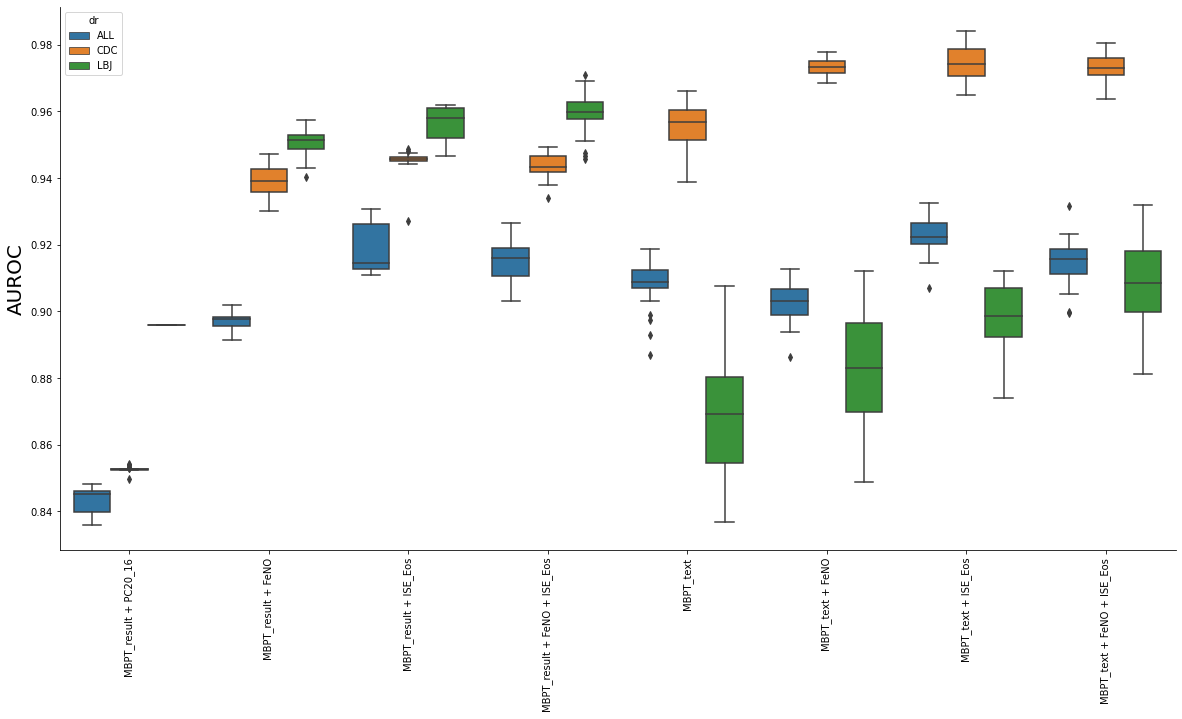

In [14]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(20,10))
x = 'variable'
y = 'test_auroc'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', 'MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('AUROC', fontsize=20)
sns.despine()

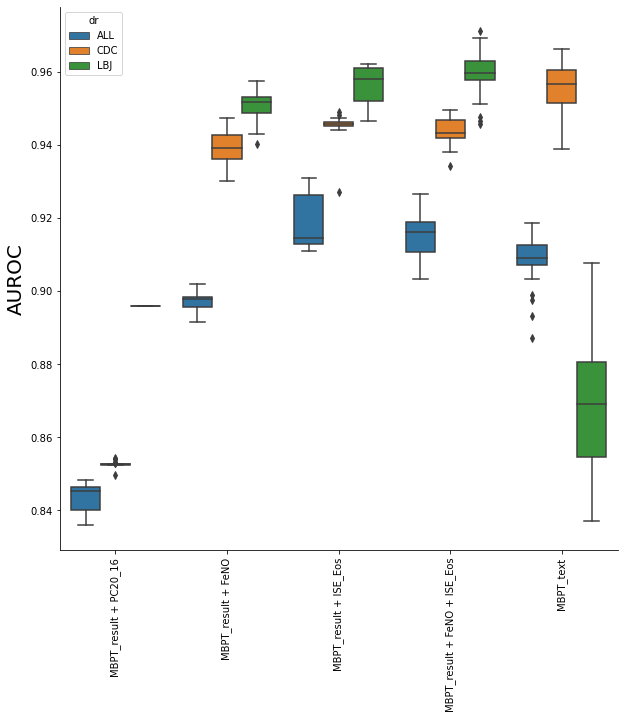

In [14]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_auroc'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', "MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=fig1_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('AUROC', fontsize=20)
sns.despine()

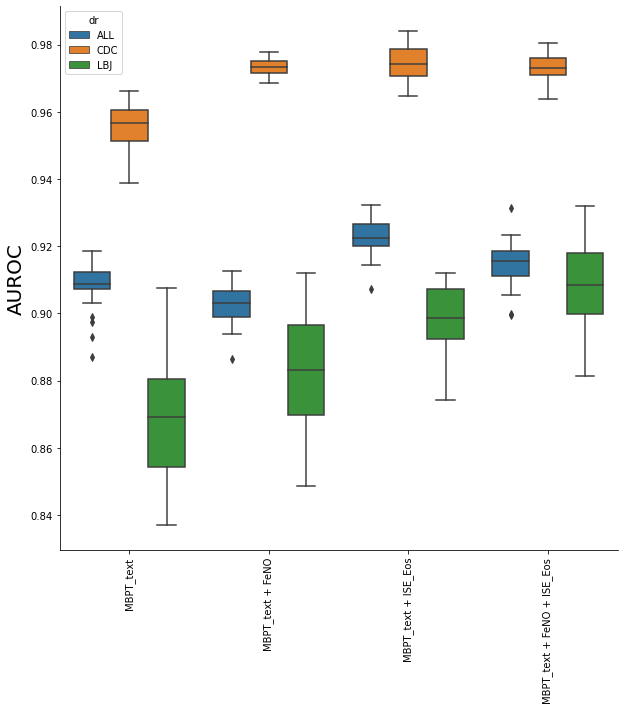

In [15]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_auroc'
order = ['MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig2_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('AUROC', fontsize=20)
sns.despine()

## AUPRC

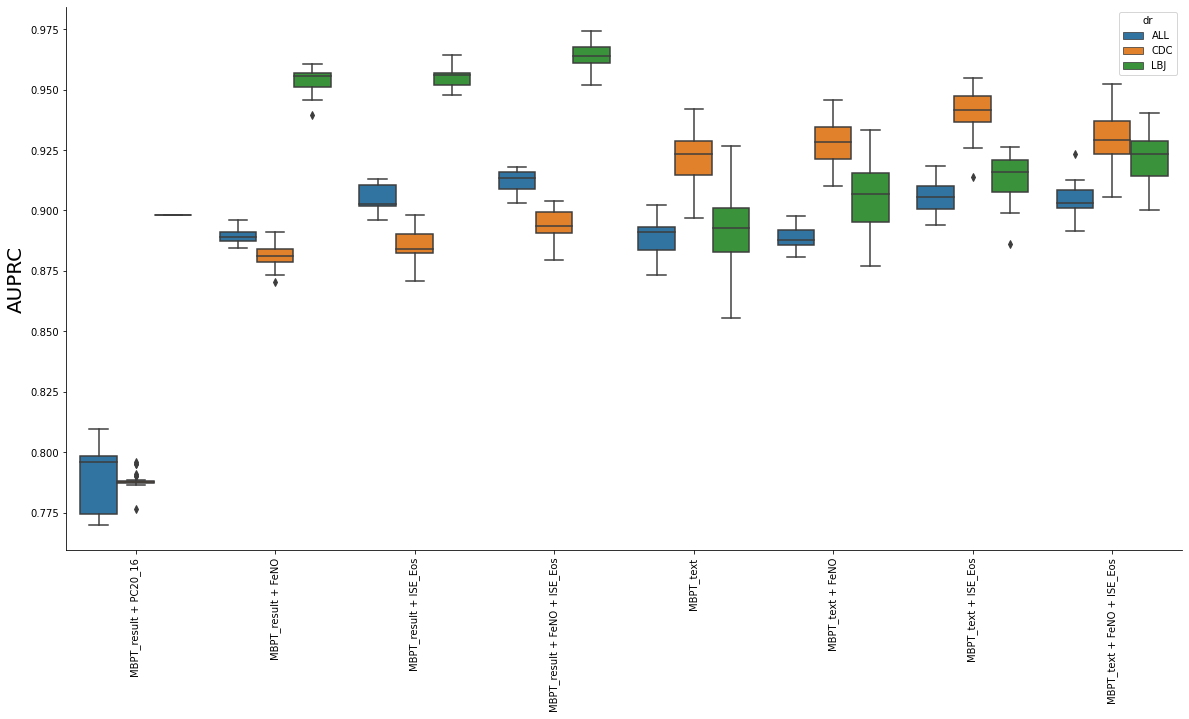

In [32]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(20,10))
x = 'variable'
y = 'test_auprc'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', 'MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('AUPRC', fontsize=20)
sns.despine()

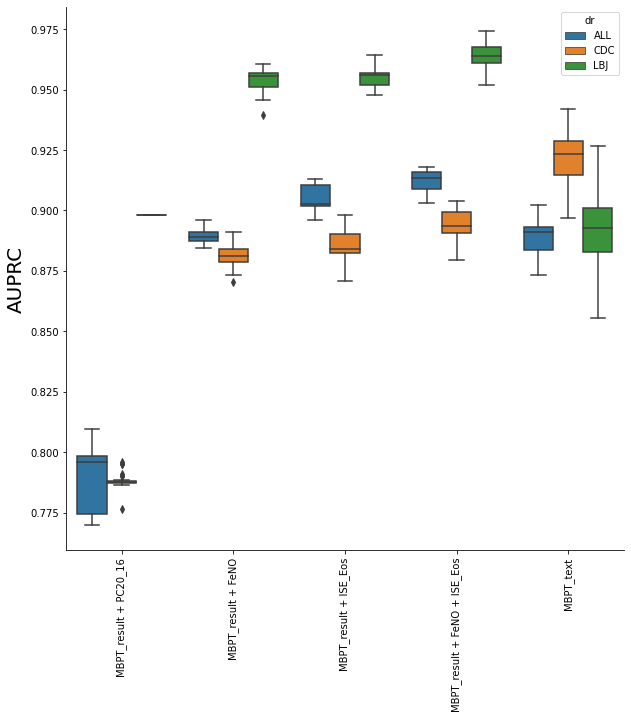

In [16]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_auprc'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', "MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=fig1_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('AUPRC', fontsize=20)
sns.despine()

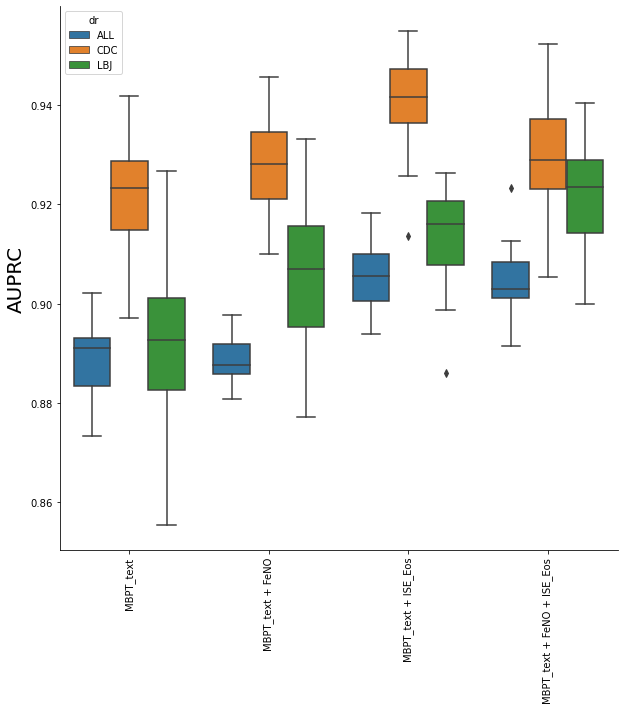

In [17]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_auprc'
order = ['MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig2_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('AUPRC', fontsize=20)
sns.despine()

## Sensitivity

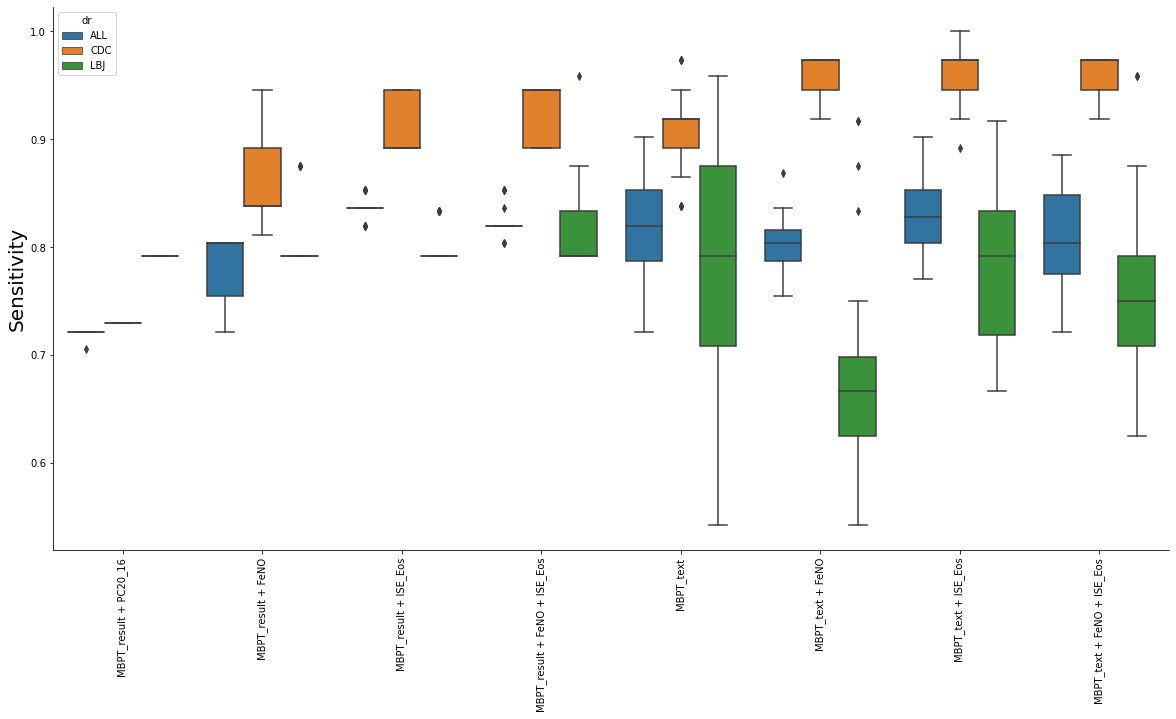

In [34]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(20,10))
x = 'variable'
y = 'test_sensitivity'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', 'MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('Sensitivity', fontsize=20)
sns.despine()

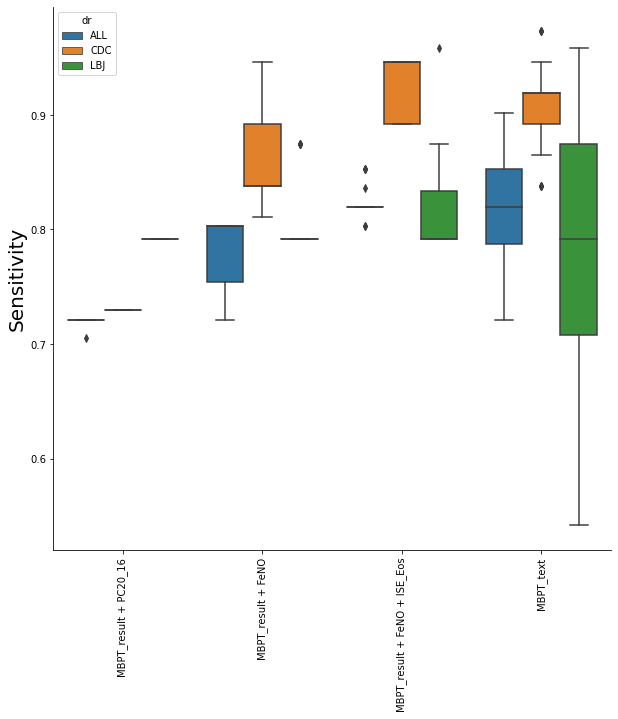

In [18]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_sensitivity'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 
         'MBPT_result + FeNO + ISE_Eos', "MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=fig1_metrics, x=x, y=y, order=order, hue='dr')


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('Sensitivity', fontsize=20)
sns.despine()

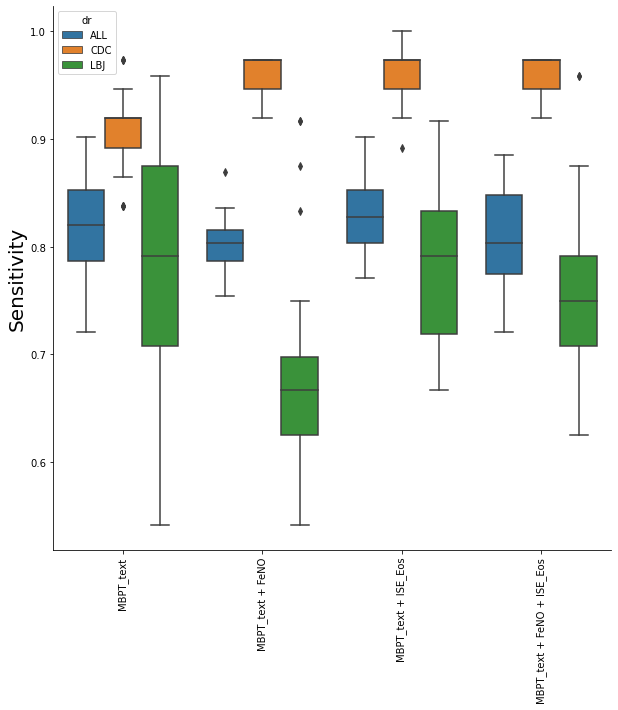

In [19]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_sensitivity'
order = ['MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig2_metrics, x=x, y=y, order=order, hue='dr')


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('Sensitivity', fontsize=20)
sns.despine()

## Specificity

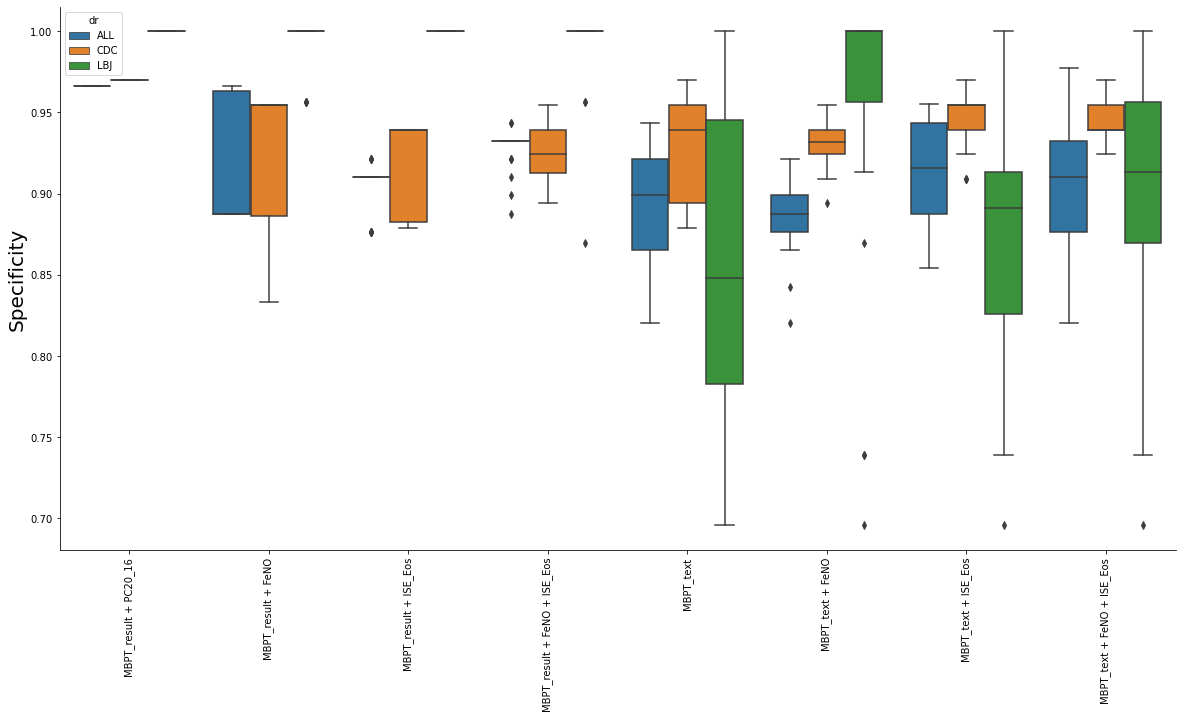

In [35]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(20,10))
x = 'variable'
y = 'test_specificity'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', 'MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('Specificity', fontsize=20)
sns.despine()

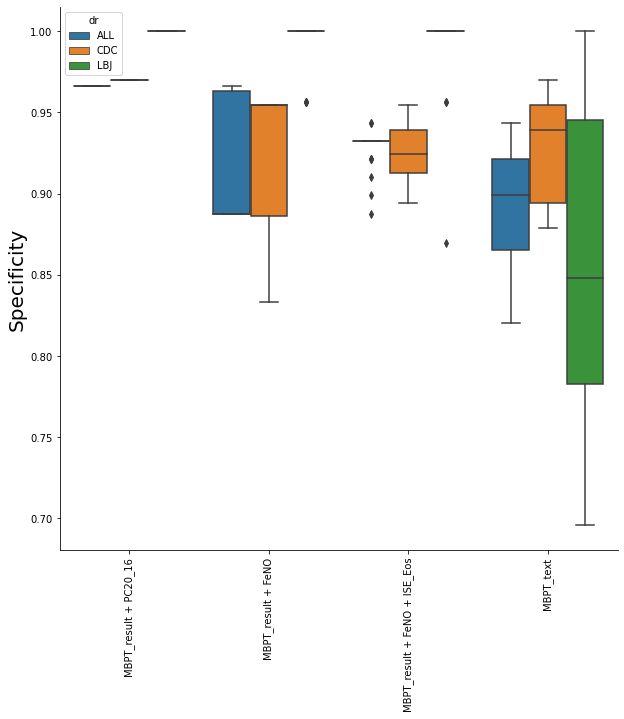

In [20]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_specificity'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 
         'MBPT_result + FeNO + ISE_Eos', "MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=fig1_metrics, x=x, y=y, order=order, hue='dr')


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('Specificity', fontsize=20)
sns.despine()

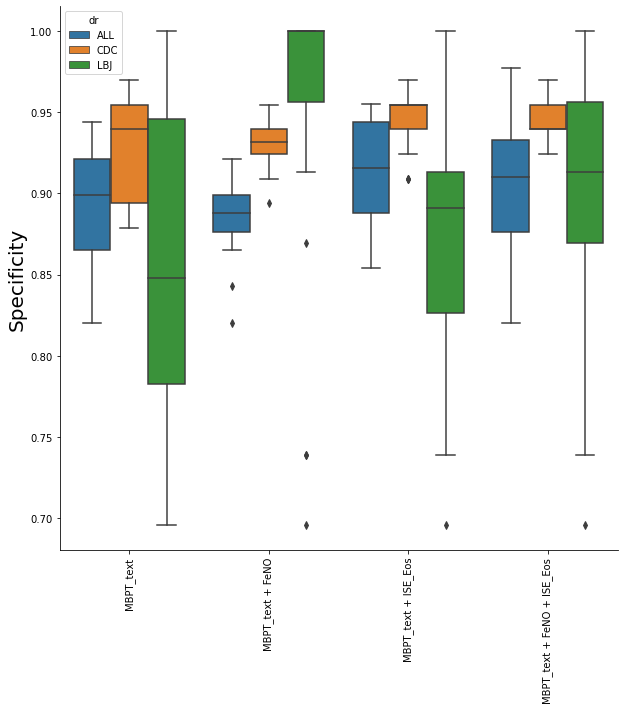

In [21]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_specificity'
order = ['MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig2_metrics, x=x, y=y, order=order, hue='dr')


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('Specificity', fontsize=20)
sns.despine()

## PPV

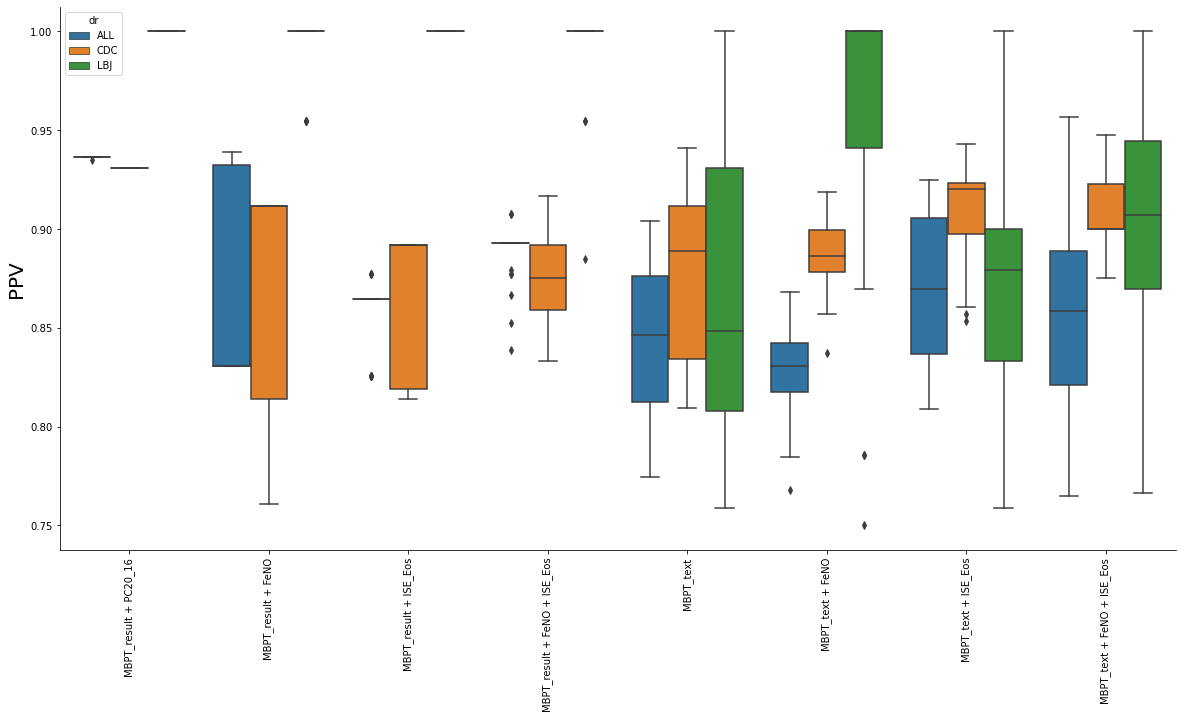

In [36]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(20,10))
x = 'variable'
y = 'test_ppv'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', 'MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('PPV', fontsize=20)
sns.despine()

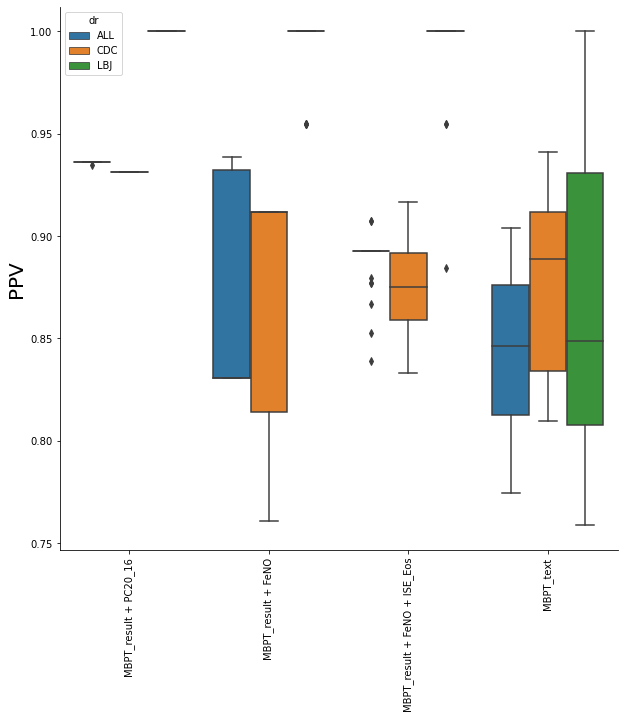

In [22]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_ppv'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 
         'MBPT_result + FeNO + ISE_Eos', "MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=fig1_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('PPV', fontsize=20)
sns.despine()

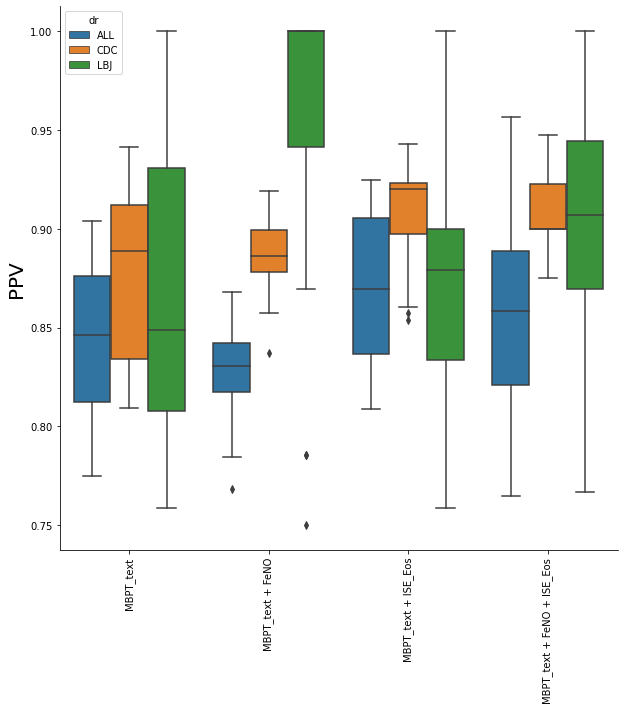

In [23]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_ppv'
order = ['MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig2_metrics, x=x, y=y, order=order, hue='dr')


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('PPV', fontsize=20)
sns.despine()

## NPV

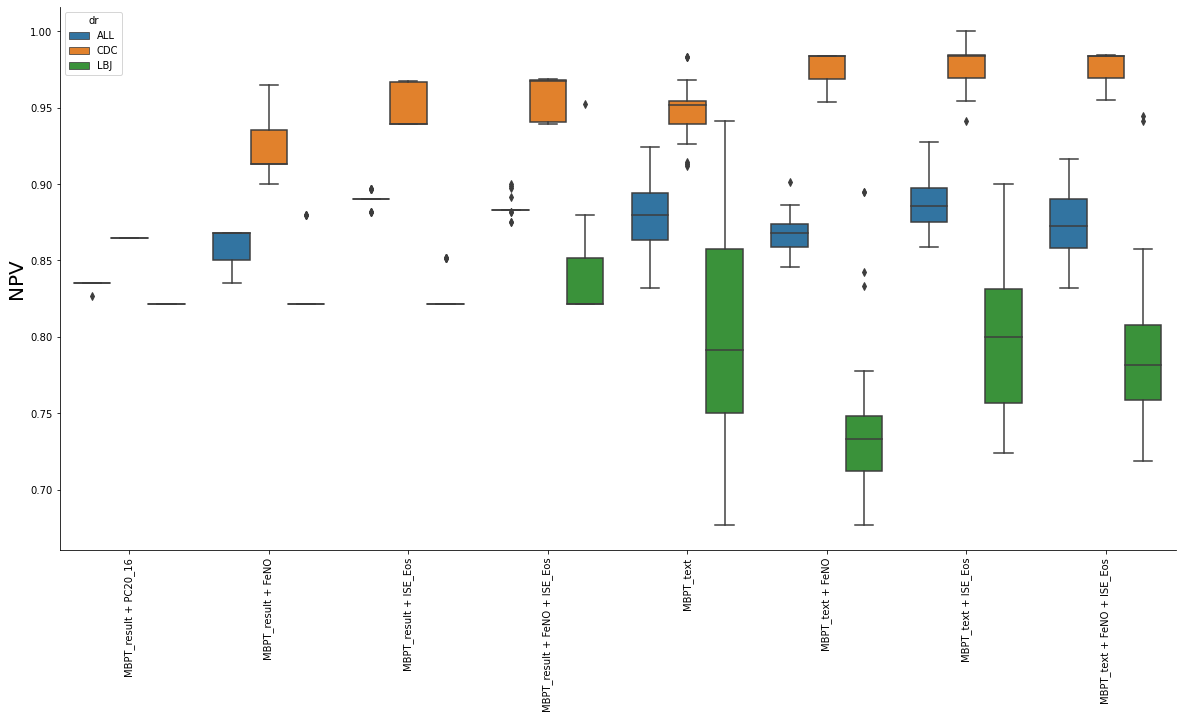

In [37]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(20,10))
x = 'variable'
y = 'test_npv'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', 'MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('NPV', fontsize=20)
sns.despine()

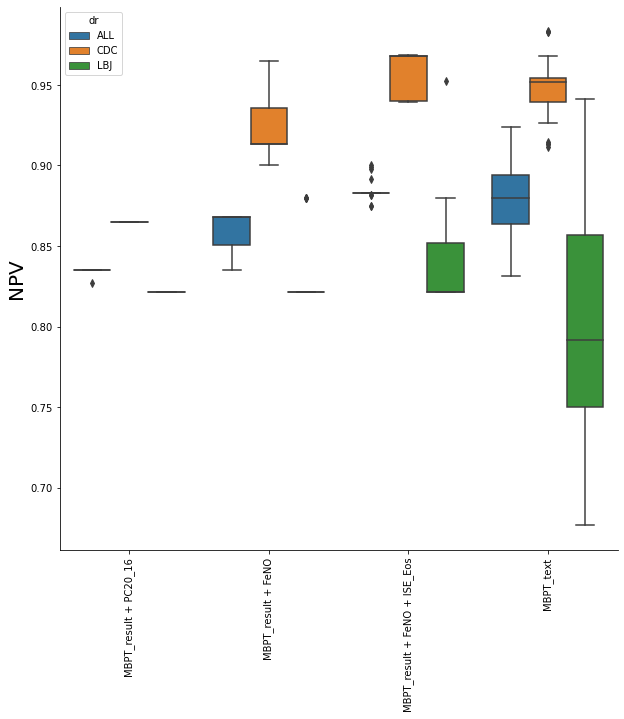

In [24]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_npv'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 
         'MBPT_result + FeNO + ISE_Eos', "MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=fig1_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('NPV', fontsize=20)
sns.despine()

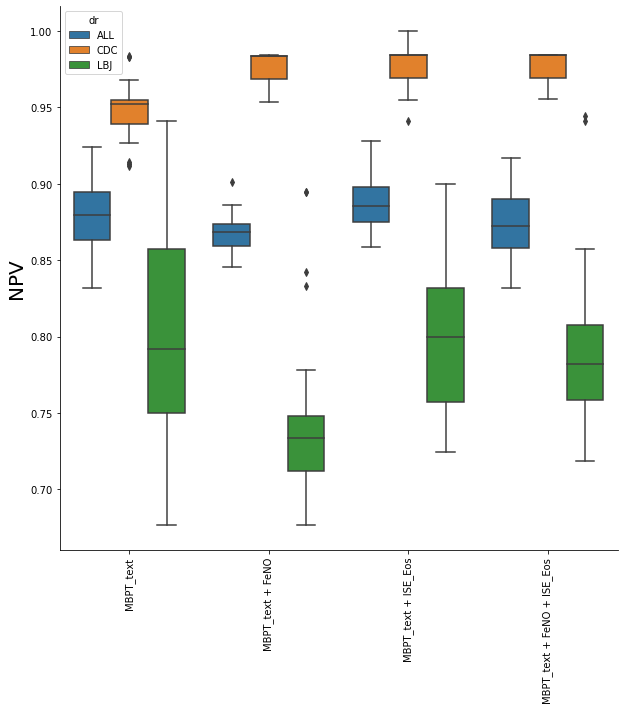

In [25]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_npv'
order = ['MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig2_metrics, x=x, y=y, order=order, hue='dr')


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('NPV', fontsize=20)
sns.despine()

## F1 Score

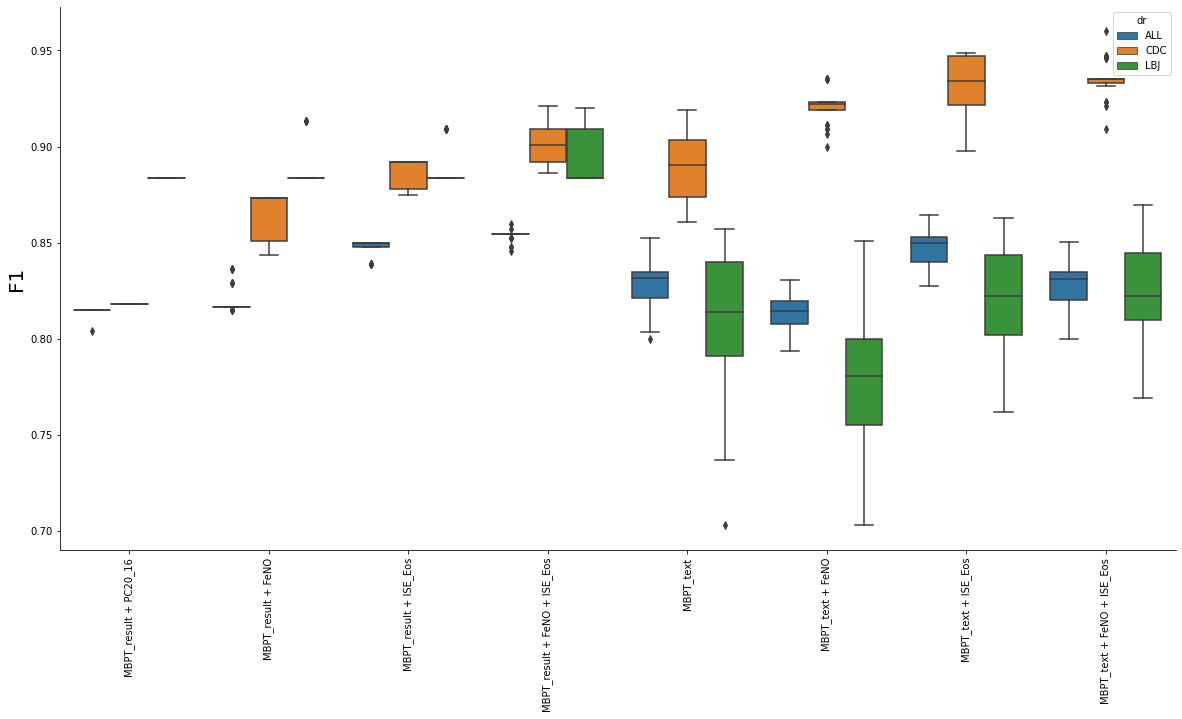

In [38]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(20,10))
x = 'variable'
y = 'test_f1'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 'MBPT_result + ISE_Eos',
         'MBPT_result + FeNO + ISE_Eos', 'MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("")
plt.ylabel('F1', fontsize=20)
sns.despine()

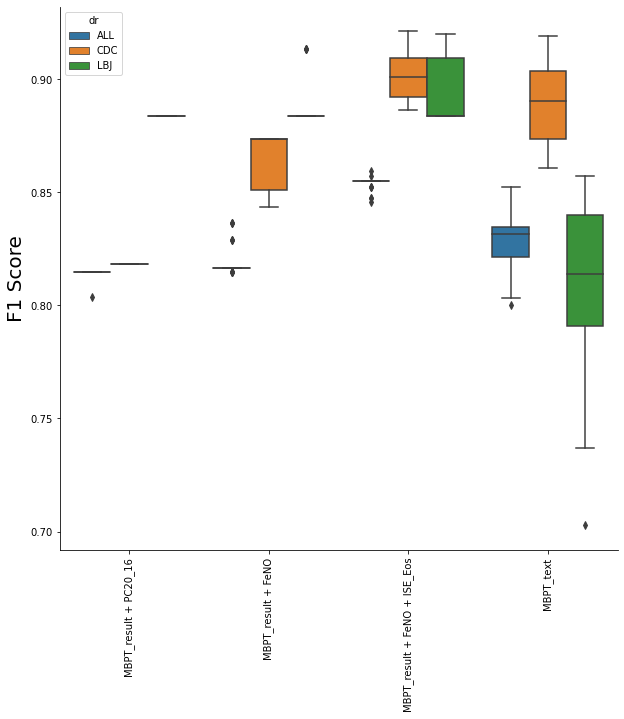

In [26]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_f1'
order = ['MBPT_result + PC20_16', 'MBPT_result + FeNO', 
         'MBPT_result + FeNO + ISE_Eos', "MBPT_text"]

combination = combinations(order, 2)
ax = sns.boxplot(data=fig1_metrics, x=x, y=y, order=order, hue='dr')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('F1 Score', fontsize=20)
sns.despine()

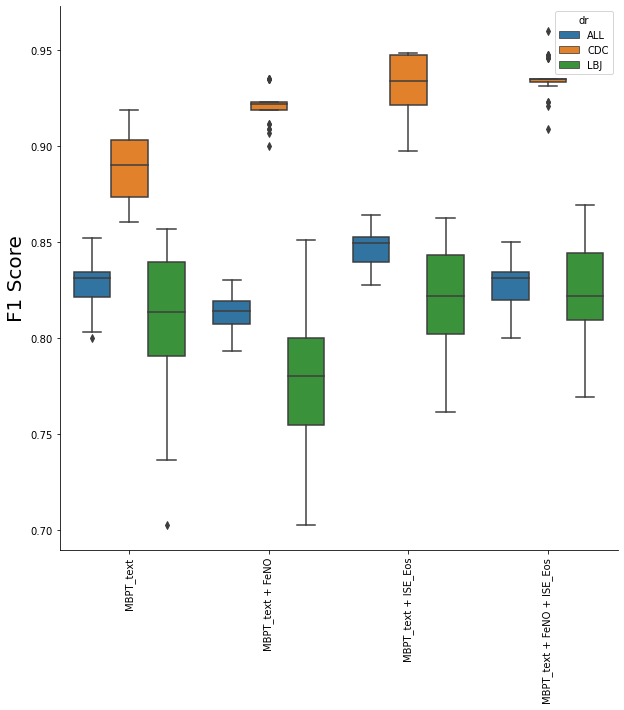

In [27]:
from itertools import combinations
from statannot import add_stat_annotation
import seaborn as sns

plt.figure(figsize=(10,10))
x = 'variable'
y = 'test_f1'
order = ['MBPT_text', 'MBPT_text + FeNO', 'MBPT_text + ISE_Eos',
         'MBPT_text + FeNO + ISE_Eos']

combination = combinations(order, 2)
ax = sns.boxplot(data=fig2_metrics, x=x, y=y, order=order, hue='dr')


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.ylim(0.89, 0.95)
plt.xlabel("")
plt.ylabel('F1 Score', fontsize=20)
sns.despine()

In [15]:
fig_metrics.to_csv('../../fig_metrics.csv', index=False)

In [20]:
fig_metrics.pivot_table(index='dr', columns=['variable'], values=['test_auroc'], aggfunc=lambda x: x)

ValueError: Function does not reduce

In [18]:
fig_metrics

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold,dr,variable
0,1,0.001,3,0.0,0.816667,0.469887,0.772280,0.698876,0.860000,0.391512,0.839934,0.774432,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.496981,ALL,MBPT_result + PC20_16
1,1,0.001,3,0.0,0.873950,0.367129,0.853580,0.818393,0.860000,0.394268,0.846196,0.798459,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.349174,ALL,MBPT_result + PC20_16
2,1,0.001,3,0.0,0.873950,0.355982,0.851232,0.822934,0.860000,0.394215,0.842144,0.787875,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.406074,ALL,MBPT_result + PC20_16
3,1,0.001,3,0.0,0.873950,0.373402,0.848151,0.790389,0.860000,0.402276,0.835789,0.780281,0.934783,0.826923,0.704918,0.966292,0.860000,0.803738,0.728045,ALL,MBPT_result + PC20_16
4,1,0.001,3,0.0,0.831933,0.414406,0.799149,0.763136,0.866667,0.391297,0.848223,0.809515,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.563677,ALL,MBPT_result + PC20_16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,0.001,2,0.0,0.810811,0.454193,0.864035,0.893744,0.808511,0.382721,0.914855,0.926830,0.863636,0.800000,0.791667,0.869565,0.829787,0.826087,0.582977,LBJ,MBPT_text + FeNO + ISE_Eos
716,1,0.001,2,0.0,0.810811,0.426109,0.871345,0.908444,0.808511,0.383231,0.901268,0.914972,0.894737,0.750000,0.708333,0.913043,0.808511,0.790698,0.626743,LBJ,MBPT_text + FeNO + ISE_Eos
717,1,0.001,2,0.0,0.891892,0.340363,0.923977,0.956028,0.787234,0.396811,0.905797,0.913003,0.900000,0.777778,0.750000,0.913043,0.829787,0.818182,0.620266,LBJ,MBPT_text + FeNO + ISE_Eos
718,1,0.001,2,0.0,0.837838,0.350397,0.912281,0.924204,0.787234,0.365196,0.915761,0.929524,0.944444,0.758621,0.708333,0.956522,0.829787,0.809524,0.662905,LBJ,MBPT_text + FeNO + ISE_Eos


,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold,dr,variable
0,1,0.001,3,0.0,0.816667,0.469887,0.772280,0.698876,0.860000,0.391512,0.839934,0.774432,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.496981,ALL,MBPT_result + PC20_16
1,1,0.001,3,0.0,0.873950,0.367129,0.853580,0.818393,0.860000,0.394268,0.846196,0.798459,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.349174,ALL,MBPT_result + PC20_16
2,1,0.001,3,0.0,0.873950,0.355982,0.851232,0.822934,0.860000,0.394215,0.842144,0.787875,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.406074,ALL,MBPT_result + PC20_16
3,1,0.001,3,0.0,0.873950,0.373402,0.848151,0.790389,0.860000,0.402276,0.835789,0.780281,0.934783,0.826923,0.704918,0.966292,0.860000,0.803738,0.728045,ALL,MBPT_result + PC20_16
4,1,0.001,3,0.0,0.831933,0.414406,0.799149,0.763136,0.866667,0.391297,0.848223,0.809515,0.936170,0.834951,0.721311,0.966292,0.866667,0.814815,0.563677,ALL,MBPT_result + PC20_16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,0.001,2,0.0,0.810811,0.454193,0.864035,0.893744,0.808511,0.382721,0.914855,0.926830,0.863636,0.800000,0.791667,0.869565,0.829787,0.826087,0.582977,LBJ,MBPT_text + FeNO + ISE_Eos
716,1,0.001,2,0.0,0.810811,0.426109,0.871345,0.908444,0.808511,0.383231,0.901268,0.914972,0.894737,0.750000,0.708333,0.913043,0.808511,0.790698,0.626743,LBJ,MBPT_text + FeNO + ISE_Eos
717,1,0.001,2,0.0,0.891892,0.340363,0.923977,0.956028,0.787234,0.396811,0.905797,0.913003,0.900000,0.777778,0.750000,0.913043,0.829787,0.818182,0.620266,LBJ,MBPT_text + FeNO + ISE_Eos
718,1,0.001,2,0.0,0.837838,0.350397,0.912281,0.924204,0.787234,0.365196,0.915761,0.929524,0.944444,0.758621,0.708333,0.956522,0.829787,0.809524,0.662905,LBJ,MBPT_text + FeNO + ISE_Eos


In [30]:
fig_metrics.pivot(columns=['variable'], values=['test_auroc'])

test_auroc                               \
variable MBPT_result + FeNO MBPT_result + FeNO + ISE_Eos   
0                       NaN                          NaN   
1                       NaN                          NaN   
2                       NaN                          NaN   
3                       NaN                          NaN   
4                       NaN                          NaN   
..                      ...                          ...   
715                     NaN                          NaN   
716                     NaN                          NaN   
717                     NaN                          NaN   
718                     NaN                          NaN   
719                     NaN                          NaN   

                                                                \
variable MBPT_result + ISE_Eos MBPT_result + PC20_16 MBPT_text   
0                          NaN              0.839934       NaN   
1                          NaN              0.846196       NaN   
2                          NaN              0.842144       NaN   
3                          NaN              0.835789       NaN   
4                          NaN              0.848223       NaN   
..                         ...                   ...       ...   
715                        NaN                   NaN       NaN   
716                        NaN                   NaN       NaN   
717                        NaN                   NaN       NaN   
718                        NaN                   NaN       NaN   
719                        NaN                   NaN       NaN   

                                                                          
variable MBPT_text + FeNO MBPT_text + FeNO + ISE_Eos MBPT_text + ISE_Eos  
0                     NaN                        NaN                 NaN  
1                     NaN                        NaN                 NaN  
2                     NaN                        NaN                 NaN  
3                     NaN                        NaN                 NaN  
4                     NaN                        NaN                 NaN  
..                    ...                        ...                 ...  
715                   NaN                   0.914855                 NaN  
716                   NaN                   0.901268                 NaN  
717                   NaN                   0.905797                 NaN  
718                   NaN                   0.915761                 NaN  
719                   NaN                   0.909420                 NaN  

[720 rows x 8 columns]

In [28]:
fig_metrics.groupby(['dr', 'variable'])['test_auroc']

In [33]:
fig_metrics[fig_metrics['dr'].isin(['LBJ', 'CDC'])]

,max_depth,learning_rate,lambda,gamma,val_scores,val_mse_loss,val_auroc,val_auprc,test_scores,test_mse_loss,test_auroc,test_auprc,test_ppv,test_npv,test_sensitivity,test_specificity,test_accuracy,test_f1,test_threshold,dr,variable
30,1,0.001,2,0.0,0.865854,0.391087,0.816851,0.737426,0.883495,0.354841,0.853194,0.790969,0.931034,0.864865,0.729730,0.969697,0.883495,0.818182,0.774250,CDC,MBPT_result + PC20_16
31,1,0.001,2,0.0,0.829268,0.435371,0.770982,0.706204,0.883495,0.356132,0.852580,0.787227,0.931034,0.864865,0.729730,0.969697,0.883495,0.818182,0.795377,CDC,MBPT_result + PC20_16
32,1,0.001,2,0.0,0.865854,0.365894,0.810345,0.754836,0.883495,0.358354,0.852580,0.787153,0.931034,0.864865,0.729730,0.969697,0.883495,0.818182,0.858259,CDC,MBPT_result + PC20_16
33,1,0.001,2,0.0,0.853659,0.430231,0.821154,0.722256,0.883495,0.362426,0.849713,0.776491,0.931034,0.864865,0.729730,0.969697,0.883495,0.818182,0.950311,CDC,MBPT_result + PC20_16
34,1,0.001,2,0.0,0.888889,0.332627,0.844828,0.800766,0.883495,0.361842,0.852375,0.786329,0.931034,0.864865,0.729730,0.969697,0.883495,0.818182,0.857370,CDC,MBPT_result + PC20_16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,0.001,2,0.0,0.810811,0.454193,0.864035,0.893744,0.808511,0.382721,0.914855,0.926830,0.863636,0.800000,0.791667,0.869565,0.829787,0.826087,0.582977,LBJ,MBPT_text + FeNO + ISE_Eos
716,1,0.001,2,0.0,0.810811,0.426109,0.871345,0.908444,0.808511,0.383231,0.901268,0.914972,0.894737,0.750000,0.708333,0.913043,0.808511,0.790698,0.626743,LBJ,MBPT_text + FeNO + ISE_Eos
717,1,0.001,2,0.0,0.891892,0.340363,0.923977,0.956028,0.787234,0.396811,0.905797,0.913003,0.900000,0.777778,0.750000,0.913043,0.829787,0.818182,0.620266,LBJ,MBPT_text + FeNO + ISE_Eos
718,1,0.001,2,0.0,0.837838,0.350397,0.912281,0.924204,0.787234,0.365196,0.915761,0.929524,0.944444,0.758621,0.708333,0.956522,0.829787,0.809524,0.662905,LBJ,MBPT_text + FeNO + ISE_Eos


In [ ]:
from Table